<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-gurobi-with-guesses-about-AR" data-toc-modified-id="Use-gurobi-with-guesses-about-AR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use gurobi with guesses about AR</a></span></li><li><span><a href="#Classical-times" data-toc-modified-id="Classical-times-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classical times</a></span><ul class="toc-item"><li><span><a href="#Helper-classes-and-functions" data-toc-modified-id="Helper-classes-and-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Helper classes and functions</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Gurobi-modeling" data-toc-modified-id="Gurobi-modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gurobi modeling</a></span><ul class="toc-item"><li><span><a href="#Gurobi-activate" data-toc-modified-id="Gurobi-activate-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Gurobi activate</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from cartesian_explorer import Explorer
import cartesian_explorer as caex

import qtensor
import socket

In [2]:
cache = caex.caches.JobLibCache("../caex_cache/energy_eff")
if socket.gethostname().startswith('skylake'):
    print('Using ray parallel for caex')
    parallel = caex.parallels.Ray(processes=55)
else:
    parallel = None
ex = Explorer(cache=cache, parallel=parallel)

Using ray parallel for caex


2021-06-11 06:36:54,314	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


## Use gurobi with guesses about AR




* $UB$ - upper bound on maxcut cost
* $LB$ - lower bound 
* $C$ - optimal cost
$UB>C$


$AR = \frac{LB}{C} > \frac{LB}{UB}$

In [4]:
import networkx as nx
from typing import Tuple
import gurobipy as gb
import time

def maxcut_bounds_history(G: nx.Graph,
                          max_time=10*60,
                          max_cost=None,
                          threads=None,
                          timedelta=3,
                          max_ar=1.0
                         ) -> Tuple[list, list]:
    p = gb.Model()
    p.setParam('TimeLimit', timedelta)
    if max_cost is not None:
        p.setParam('BestObjStop', max_cost)
    if threads is not None:
        p.setParam('Threads', threads)
    vdict = {}
    for n in G.nodes:
        vdict[n] = p.addVar(name='v_'+str(n), vtype=gb.GRB.BINARY)
    scaled_v = {v:(2*x - 1) for v, x in vdict.items()}
    C_i = [vdict[i] + vdict[j] - 2*vdict[i]*vdict[j] for i, j in G.edges]
    
    p.setObjective(sum(C_i), gb.GRB.MAXIMIZE)
    
    start = time.time()
    upper = []
    lower = []
    while time.time() - start < max_time:
        p.optimize()
        upper.append(p.ObjBound)
        lower.append(p.ObjVal)
        if upper[-1] == lower[-1]:
            print('Found an optimal solution!')
            break
        if lower[-1]/upper[-1] > max_ar:
            print('Found a good enough AR')
            break
            
        
    return upper, lower



Set gurobi thread count to 1, so it's more meaningful to compare between different machines and more correct when doing parallel calculations

In [5]:
GUROBI_THREADS = 1 #set to 0 to use all available

## Classical times

In [6]:
@ex.provider
def graph(N, seed=10):
    return qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=3)

@ex.add_function(provides=('classical_time_gurobi', 'opt_cost'), requires=('graph', ))
def classical_time_gurobi(graph):
    start = time.time()
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_time=15*60, threads=GUROBI_THREADS)
    return time.time() - start, c
    
@ex.provider
def classical_time_gw(graph):
    start = time.time()
    c = qtensor.tools.maxcut.goemans_williamson.gw_cost(graph)
    return time.time() - start
    

In [7]:
@ex.provider
def classical_time_match_cost(graph, approx_ratio):
    start = time.time()
    upper, lower = maxcut_bounds_history(graph, max_ar=approx_ratio, threads=GUROBI_THREADS)
    return time.time() - start
    

In [8]:
@ex.provider
def approx_ratio(p):
    try:
        AR = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']
        if AR>0:
            return AR
        else:
            raise KeyError
    except KeyError:
        AR = 1 - (0.3-np.log2(p)*0.05)
    return AR

### Helper classes and functions

In [9]:
def log_linear_fit(x, y, x_ext):
    a = np.polyfit(x, np.log(y), deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return np.exp(ln)

def linear_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def cubic_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=3)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def octa_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=6)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

In [10]:
from dataclasses import dataclass

@dataclass
class Line:
    x: np.array 
    y: np.array
        
    def average_flat(self):
        if len(self.y.shape)>1:
            self.std = np.nanstd(self.y, -1)
            self.y = np.nanmean(self.y, -1)
            
@dataclass
class LineFit(Line):
    def log_linear_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = log_linear_fit(self.x, self.y, self.fit_x)
        return self.fit
    
    def cubic_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = cubic_fit(self.x, self.y, self.fit_x)
        return self.fit

In [11]:
# depr
def get_classical_data(p=30, approx_ratio=0.937
                  , match_max_N=1150, opt_max_N=310
                  , gw_max_N=160
                  , max_N = 3000
                       , seeds = [10, 11]
                 ):

    
    x_gw = np.array(range(10, gw_max_N, 18))
    gw_time = ex.map_variable(('classical_time_gw')
                     , N=x_gw
                     )
    x_ext = np.arange(10, 3400, 12)
    gw_fit = cubic_fit(x_gw, gw_time, x_ext)
    gw = LineFit(x=x_gw, y=gw_time)
    gw.cubic_fit(x_ext)
    return gw, opt, match



In [12]:
import xarray as xar

In [56]:
max_N = 3000
opt_max_N = 450
seeds = [10, 11, 12, 13, 14]

In [57]:
x_ext = np.array(range(10, max_N, 36))
x_opt = np.array(range(10, opt_max_N, 16))

opt_time = ex.map_variable(('classical_time_gurobi')
                           , N=x_opt
                           , seed=seeds
                 )

opt_ext = np.arange(10, 400, 16)

In [60]:
opt = xar.DataArray(opt_time, dims=('N', 'seeds'), coords=(x_opt, seeds))

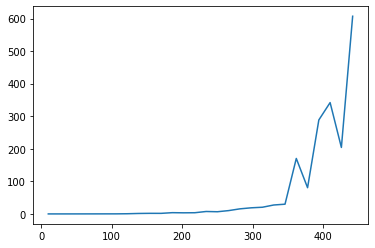

In [61]:
# check the data
plt.plot(x_opt, np.mean(opt_time, -1))

In [48]:
ps = [6, 12, 20, 26, 32]
seeds = range(10, 20)

In [49]:
approx_ratio(26)

0.9350219859070545

In [71]:
match_ext = np.arange(10, 4800, 32*4)
#match_ext = np.concatenate((match_ext, np.array([30000])))
match_time = ex.map_variable(('classical_time_match_cost')
                             , p=ps
                             , N=match_ext
                             , seed=seeds
                 )

2021-06-11 10:18:20,171	WARNING worker.py:1091 -- WARNING: 170 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.
2021-06-11 10:18:20,185	WARNING worker.py:1091 -- WARNING: 171 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.
2021-06-11 10:18:20,896	WARNING worker.py:1091 -- WARNING: 172 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.
2021-06-11 10:18:20,925	WARNING worker.py:1091 -- WARNING: 173 PYTHON workers have been started. This could b

In [68]:
match = xar.DataArray(match_time, dims=('p', 'N', 'seeds'), coords=(ps, match_ext, seeds))

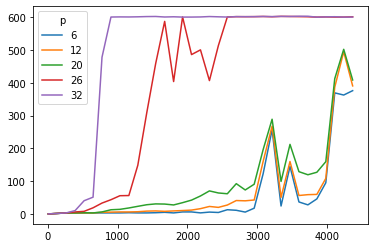

In [69]:
# check the data
for p in ps:
    plt.plot(match_ext, np.mean(match.sel(p=p), -1), label=str(p))
plt.legend(title='p')
plt.savefig('../tmp_plot_gurobi_match_vsN_vsp.pdf')

In [70]:
match.to_netcdf('../gurobi_match_threads1.nc')
opt.to_netcdf('../gurobi_opt_threads1.nc')

## Plot

In [17]:
ex.use_svg()

In [18]:
def plot_advantage(p=6, n_samples=1e3):
    fig = plt.figure(figsize=(8, 4))

    gw, opt, match = get_classical_data(p=p, approx_ratio=AR
                                        , max_N=18500
                                        , opt_max_N=350
                                        , gw_max_N=160
                                        ,seeds=[10, 11, 12]
                                        )

    qaoa_transport = get_quantum_data(p=p, var_name='qaoa_time_transport',
                                      max_N=10000, n_samples=n_samples)
    qaoa_dst_seq = get_quantum_data(p=p, var_name='qaoa_time_destructive_sequential',
                                    max_N=10000, n_samples=n_samples)

    plt.yscale('log')
    plt.xscale('log')

    plt.plot(qaoa_transport.x, qaoa_transport.y, color='red',
             label=f'QAOA w/ transport time (quality={np.round(AR, 3)})')
    plt.plot(qaoa_dst_seq.x, qaoa_dst_seq.y, color='orange',
             label=f'QAOA w/ destructive sequential time (quality={np.round(AR, 3)})')
    plt.plot(gw.x, gw.y, '*-', color='green', label='Goemans-Williamson (quality=0.878)')
    plt.plot(opt.x, opt.y, '*-', color='blue', label='Gurobi: optimal (quality=1.0)')
    if hasattr(opt, 'std'):
        plt.fill_between(opt.x, opt.y+opt.std, opt.y-opt.std,
                         color='blue', alpha=0.15 )
    match.average_flat()
    plt.plot(match.x, match.y, '*-', color='magenta',
             label=f'Gurobi: optimal (quality={np.round(AR, 3)})')
    if hasattr(match, 'std'):
        plt.fill_between(match.x, match.y+match.std, match.y-match.std,
                         color='magenta', alpha=0.15 )
    plt.plot(opt.fit_x, opt.fit, '--', color='black', label='log-linear fit')
    plt.plot(gw.fit_x, gw.fit, '--', color='black')
    plt.legend(loc='upper left')
    plt.ylabel('Time to solution')
    plt.title(f'p={p}, n_samples={int(n_samples)}')
    plt.grid()

In [19]:
plot_advantage(p=6)
plt.savefig("./pdf/p6_time_vs_n.pdf")

RayTaskError(SolverError): [36mray::call_update()[39m (pid=63649, ip=10.17.6.147)
  File "python/ray/_raylet.pyx", line 482, in ray._raylet.execute_task
  File "/home/danlkv/side/cartesian-explorer/cartesian_explorer/tools/ray_progressbar.py", line 54, in call_update
    r = func(*args, **kwargs)
  File "/home/danlkv/side/cartesian-explorer/cartesian_explorer/parallels.py", line 11, in apply_kwargs
    return func(**kwargs)
  File "/home/danlkv/side/cartesian-explorer/cartesian_explorer/Explorer.py", line 254, in get_variables
    current_blackboard = self._apply_functions(reversed(funcs), current_blackboard)
  File "/home/danlkv/side/cartesian-explorer/cartesian_explorer/Explorer.py", line 235, in _apply_functions
    retval = f(**call_kwd)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/joblib/memory.py", line 591, in __call__
    return self._cached_call(args, kwargs)[0]
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/joblib/memory.py", line 534, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/joblib/memory.py", line 761, in call
    output = self.func(*args, **kwargs)
  File "<ipython-input-12-9365b445752b>", line 14, in classical_time_gw
  File "/home/danlkv/anl/Qensor/qtensor/tools/maxcut/goemans_williamson.py", line 17, in gw_cost
    solnGW_binary = gw_solution(G)
  File "/home/danlkv/anl/Qensor/qtensor/tools/maxcut/goemans_williamson.py", line 8, in gw_solution
    solnGW = cvx.algorithms.goemans_williamson_weighted(G)  # Goemans Williamson algorithm
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/cvxgraphalgs/algorithms/max_cut.py", line 66, in goemans_williamson_weighted
    solution = _solve_cut_vector_program(adjacency)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/cvxgraphalgs/algorithms/max_cut.py", line 92, in _solve_cut_vector_program
    problem.solve()
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/cvxpy/problems/problem.py", line 436, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/cvxpy/problems/problem.py", line 931, in _solve
    self.unpack_results(solution, solving_chain, inverse_data)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/cvxpy/problems/problem.py", line 1251, in unpack_results
    raise error.SolverError(
cvxpy.error.SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

<Figure size 576x288 with 0 Axes>

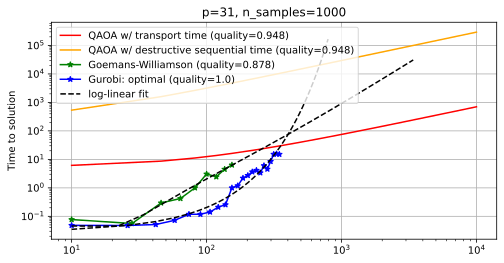

In [24]:
    plot_advantage(p=31)

## Gurobi modeling

In [20]:
import tqdm.auto as tqdm

In [41]:
SEEDS = range(1, 15)

In [ ]:
updata = []
ldata = []
for seed in tqdm.tqdm(SEEDS):
    G = nx.random_regular_graph(3, 250, seed=seed)
    upper, lower = maxcut_bounds_history(G, max_time=45, timedelta=1)
    updata.append(upper)
    ldata.append(lower)

Changed value of parameter TimeLimit to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 375 rows, 625 columns, 1125 nonzeros
Variable types: 0 continuous, 625 integer (625 binary)

Root relaxation: objective -3.750000e+02, 254 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

   808   391  350.66667    7  299  342.00000  354.20000  3.57%   103    7s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 91

Explored 843 nodes (88103 simplex iterations) in 1.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 342 341 338 ... -0

Time limit reached
Best objective 3.420000000000e+02, best bound 3.540000000000e+02, gap 3.5088%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bou

  Gomory: 4
  MIR: 1
  Zero half: 94

Explored 2690 nodes (279743 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.520000000000e+02, gap 2.6239%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  2690   956  345.14286   13  286  343.00000  352.00000  2.62%   104   17s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97


Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  4553  1375     cutoff   14       343.00000  350.83333  2.28%   102   26s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97

Explored 4833 nodes (491284 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.500000000000e+02, gap 2.0408%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective ter


Explored 6894 nodes (689371 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0xa671ae8a
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  6894  1767  345.63636   12  297  343.00000  349.92806  2.02%   100   35s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97

Explored 7202 nodes (719463 simplex 

Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  9549  2039  346.17333   12  297  343.00000  349.30714  1.84%  98.1   44s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 97

Explored 9880 nodes (969294 simplex iterations) in 1.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Changed value of parameter TimeLimit to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprin


Solution count 6: 340 339 335 ... -0

Time limit reached
Best objective 3.400000000000e+02, best bound 3.550000000000e+02, gap 4.4118%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1173   735  347.50000   26  244  340.00000  355.83333  4.66%  59.3    7s
* 1302   704              37     341.0000000  355.83333  4.35%  60.6    8s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 71

Explored 1313 nodes (80550 simplex iterations) in 1.05 seconds
Thread cou

Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  3754  1156  346.00000   25  267  342.00000  352.00000  2.92%  77.0   16s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 3764 nodes (291026 simplex iterations) in 1.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 342 341 340 ... -0

Time limit reached
Best objective 3.420000000000e+02, best bound 3.520000000000e+02, gap 2.9240%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 col


Continuing optimization...

  6242  1857  346.50000   25  254  342.00000  350.75000  2.56%  76.8   24s
  6528  1911  344.00000   27  262  342.00000  350.50000  2.49%  76.8   25s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 6705 nodes (514911 simplex iterations) in 1.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 342 341 340 ... -0

Time limit reached
Best objective 3.420000000000e+02, best bound 3.500000000000e+02, gap 2.3392%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved:

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  9874  2231     cutoff   30       343.00000  349.50000  1.90%  74.2   34s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 10405 nodes (769311 simplex iterations) in 1.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Gurobi Optimizer version 9.1.2 build

Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

 13392  2367     cutoff   30       343.00000  349.00000  1.75%  72.5   43s

Cutting planes:
  Gomory: 5
  MIR: 2
  Zero half: 72

Explored 13956 nodes (1008904 simplex iterations) in 1.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 343 342 341 ... -0

Time limit reached
Best objective 3.430000000000e+02, best bound 3.490000000000e+02, gap 1.7493%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x68776f03
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1

Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.560000000000e+02, gap 3.4884%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1066   651  356.23810   15  274  344.00000  356.23810  3.56%  68.1    7s

Cutting planes:
  Gomory: 3
  MIR: 1
  Zero half: 49

Explored 1068 nodes (74025 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available p

Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  2576   551  348.13514   23  288  344.00000  351.92857  2.30%  80.5   15s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 54

Explored 2893 nodes (242369 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.510000000000e+02, gap 2.0349%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective t


Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 63

Explored 5262 nodes (483322 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.490000000000e+02, gap 1.4535%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  5262   652  345.43750   25  280  344.00000  349.10870  1.49%  91.6   25s

Cutting planes:
  Gomory: 4
  MIR:

Model fingerprint: 0x39ace8a8
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  7515   525  346.90361   24  296  344.00000  348.02500  1.17%  93.7   33s

Cutting planes:
  Gomory: 4
  MIR: 1
  Zero half: 63

Explored 7870 nodes (736737 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 342 341 ... 312

Time limit reached
Best objective 3.440000000000e+02, best bound 3.470000000000e+02, gap 0.8721%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x39ace8a8
Model

Presolve time: 0.00s
Presolved: 375 rows, 625 columns, 1125 nonzeros
Variable types: 0 continuous, 625 integer (625 binary)

Root relaxation: objective -3.750000e+02, 261 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  375.00000    0  250   -0.00000  375.00000      -     -    0s
H    0     0                     319.0000000  375.00000  17.6%     -    0s
     0     0  362.75000    0  265  319.00000  362.75000  13.7%     -    0s
H    0     0                     320.0000000  362.75000  13.4%     -    0s
H    0     0                     322.0000000  362.75000  12.7%     -    0s
H    0     0                     332.0000000  362.75000  9.26%     -    0s
     0     0  358.66667    0  280  332.00000  358.66667  8.03%     -    0s
     0     0  358.66667    0  279  332.00000  358.66667  8.03%     -    0s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 5

Best objective 3.410000000000e+02, best bound 3.530000000000e+02, gap 3.5191%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x88128fbc
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1279   679 infeasible   30       341.00000  353.36538  3.63%  54.4    8s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 98
  RLT: 1

Explored 1325 nodes (73742 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 341 339 338 ... -0

Time limit reached
Best objective 3.41000000000

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x88128fbc
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  2938   364  345.58333   24  286  344.00000  349.25000  1.53%  74.1   16s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 98
  RLT: 1

Explored 3236 nodes (239231 simplex iterations) in 1.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 343 342 ... 322

Time limit reached
Best objective 3.440000000000e+02, best bound 3.480000000000e+02, gap 1.1628%
Gurobi Optimizer version 9

  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  5287   153  345.75000   25  280  344.00000  347.20000  0.93%  75.9   25s

Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 98
  RLT: 1

Explored 5651 nodes (431171 simplex iterations) in 1.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 344 343 342 ... 322

Time limit reached
Best objective 3.440000000000e+02, best bound 3.460000000000e+02, gap 0.5814%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x88128fbc
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00,


Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 74

Explored 1303 nodes (119500 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 345 344 343 ... -0

Time limit reached
Best objective 3.450000000000e+02, best bound 3.570000000000e+02, gap 3.4783%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  1303   737  347.00000   13  267  345.00000  357.31250  3.57%  91.0    6s

Cutting planes:
  Gomory: 6
  MIR: 1

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  3841  1613  350.50000   15  247  346.00000  355.42857  2.73%  79.6   15s
H 3855  1459                     347.0000000  355.42857  2.43%  79.7   15s

Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 75

Explored 4182 nodes (335237 simplex iterations) in 1.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 347 346 345 ... -0

Time limit reached
Best objective 3.470000000000e+02, best bound 3.550000000000e+02, gap 2.3055%
Gurobi Optimizer ve

  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  6721  1935  352.75000   10  256  347.00000  354.00000  2.02%  80.4   23s

Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 76

Explored 7057 nodes (564979 simplex iterations) in 1.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 347 346 345 ... -0

Time limit reached
Best objective 3.470000000000e+02, best bound 3.530000000000e+02, gap 1.7291%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Pre

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 0 rows, 250 columns and 0 nonzeros
Model fingerprint: 0x9f5fbe5c
Model has 375 quadratic objective terms
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolved: 375 rows, 625 columns, 1125 nonzeros

Continuing optimization...

  9571  2308  348.50000   24  235  347.00000  353.00000  1.73%  81.0   33s

Cutting planes:
  Gomory: 6
  MIR: 1
  Zero half: 76

Explored 10036 nodes (809358 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 347 346 345 ... -0

Time limit reached
Best objective 3.470000000000e+02, best bound 3.530000000000e+02, gap 1.7291%
Gurobi Optimizer version 9.1.2 build

Text(0, 0.5, 'Cost value')

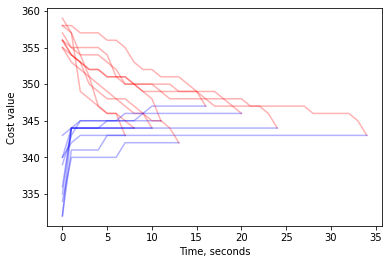

In [25]:
for upper, lower in zip(updata, ldata):
    plt.plot(upper, label='upper', alpha=0.3, color='r')
    plt.plot(lower, label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

Text(0, 0.5, 'Cost value')

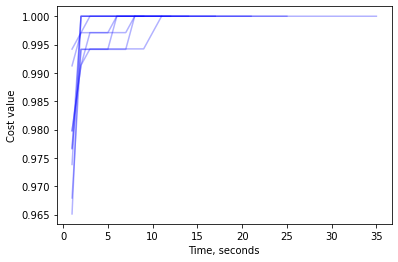

In [35]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(1, len(lower)+1)
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

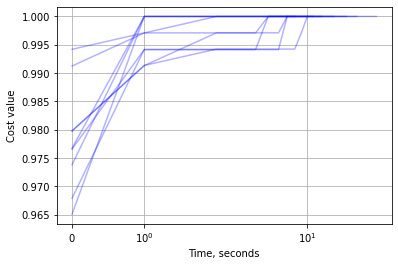

In [38]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(0, len(lower))
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
plt.xscale('symlog')    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')
plt.grid()

### Gurobi activate

In [16]:
import socket

if socket.gethostname() == 'DESKTOP-1OG5J92':
    gurobi_lic = '/home/plate/git-built/gurobi/'
    print('getting license')
    grbkey = '119a6834-b2ea-11eb-97fc-0242ac130002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey
    
elif socket.gethostname().startswith('skylake'):
    gurobi_lic = '/home/danlkv/git-build/gurobi/'
    print('getting license')
    grbkey = '2dac8036-b275-11eb-8de5-0242ac130002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey

getting license
info  : grbgetkey version 9.1.2, build v9.1.2rc0
info  : Contacting Gurobi license server...
info  : License file for license ID 631337 was successfully retrieved
info  : License expires at the end of the day on 2021-07-10
info  : Saving license file...
info  : License 631337 written to file /home/danlkv/git-build/gurobi/gurobi.lic


In [11]:
socket.gethostname()

'skylake10'

In [12]:
qtensor.tools.maxcut.gurobi_maxcut(nx.random_regular_graph(3, 12))

Academic license - for non-commercial use only - expires 2021-07-11
Using license file /home/danlkv/git-build/gurobi/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 56 physical cores, 112 logical processors, using up to 32 threads
Optimize a model with 0 rows, 12 columns and 0 nonzeros
Model fingerprint: 0xf04c708c
Model has 18 quadratic objective terms
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve time: 0.01s
Presolved: 18 rows, 30 columns, 54 nonzeros
Variable types: 0 continuous, 30 integer (30 binary)

Root relaxation: objective -1.800000e+01, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

(16.0, [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1])